In [1]:
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir)

import tensorflow as tf
from tensorflow.python.keras import layers, models
import numpy as np
import capsnet
import capsule_layers
import Dataset
import Model_functions as mf
import Audio_functions as af

import IPython.display as ipd
import matplotlib.pyplot as plt


C:\Program Files\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
#  Set other variables
sample_rate=16384
n_fft=1024
fft_hop=256
patch_window=256
patch_hop=128
n_parallel_readers=2
normalise=True
batch_size = 5
shuffle=False
n_shuffle = 10

directory_a = 'C:/Users/Toby/MSc_Project/Test_Audio/CHiME/test/Mixed'
directory_b = 'C:/Users/Toby/MSc_Project/Test_Audio/CHiME/test/Voice'

#  Create the pipeline
tf.reset_default_graph()
data = Dataset.zip_files(directory_a, directory_b)
data = Dataset.get_paired_dataset(data,
                                  sample_rate,
                                  n_fft,
                                  fft_hop,
                                  patch_window,
                                  patch_hop,
                                  n_parallel_readers,
                                  batch_size,
                                  n_shuffle,
                                  normalise)

#  Create the iterator
mixed_spec, voice_spec, mixed_audio, voice_audio = data.make_one_shot_iterator().get_next()

#  Create variable placeholders
is_training = tf.placeholder(shape=(), dtype=bool)
mixed_mag = tf.expand_dims(mixed_spec[:, :, :-1, 0], 3)
mixed_phase = tf.expand_dims(mixed_spec[:, :, :-1, 1], 3)
voice_mag = tf.expand_dims(voice_spec[:, :, :-1, 0], 3)

In [3]:
class SegCaps_CapsNetBasic(object):
    
    def __init__(self, mixed_mag, mixed_phase, voice_mag, is_training, reuse=True, name='SegCaps_CapsNetBasic'):
        """
        input_tensor: Tensor with shape [batch_size, height, width, channels]
        is_training:  Boolean - should the model be trained on the current input or not
        name:         Model instance name
        """
        with tf.variable_scope(name):
            self.mixed_mag = mixed_mag
            self.mixed_phase = mixed_phase
            self.voice_mag = voice_mag
            
            with tf.variable_scope('Convolution'):
                conv1 = mf.conv(mixed_mag, filters=128, kernel_size=5, stride=(1, 1))
                
                # Reshape layer to be 1 capsule x [filters] atoms
                _, H, W, C = conv1.get_shape()
                conv1 = layers.Reshape((H.value, W.value, 1, C.value))(conv1)
                self.conv1 = conv1
            
            with tf.variable_scope('Primary_Caps'):
                primary_caps = capsule_layers.ConvCapsuleLayer(kernel_size=5, num_capsule=8, num_atoms=32, strides=1, padding='same',
                                                               routings=1, name='primarycaps')(conv1)
                self.primary_caps = primary_caps
                
            with tf.variable_scope('Seg_Caps'):
                seg_caps = capsule_layers.ConvCapsuleLayer(kernel_size=1, num_capsule=1, num_atoms=16, strides=1, padding='same',
                                                           routings=3, name='seg_caps')(primary_caps)
                self.seg_caps = seg_caps
            
            with tf.variable_scope('Reconstruction'):
                reconstruction = capsule_layers.ConvCapsuleLayer(kernel_size=1, num_capsule=1, num_atoms=1, strides=1, padding='same',
                                                           routings=3, name='seg_caps')(primary_caps)
                reconstruction = tf.squeeze(reconstruction,-1)
                self.reconstruction = reconstruction
            
            self.cost = mf.l1_loss(self.reconstruction, voice_mag)

            self.optimizer = tf.train.AdamOptimizer(
                learning_rate=0.0002,
                beta1=0.5,
            )
            self.train_op = self.optimizer.minimize(self.cost)

In [10]:
class UNetModel(object):
    """
    Top level U-Net object.
    Attributes:
        mixed_mag: Input placeholder for magnitude spectrogram of mixed signals (voice plus background noise) - X
        voice_mag: Input placeholder for magnitude spectrogram of isolated voice signal - Y
        mixed_phase: Input placeholder for phase spectrogram of mixed signals (voice plus background noise)
        mixed_audio: Input placeholder for waveform audio of mixed signals (voice plus background noise)
        voice_audio: Input placeholder for waveform audio of isolated voice signal
        variant: The type of U-Net model (Normal convolutional or capsule based)
        is_training: Boolean - should the model be trained on the current input or not
        name: Model instance name
    """
    def __init__(self, mixed_mag, voice_mag, mixed_phase, mixed_audio, voice_audio, variant, is_training, name):
        with tf.variable_scope(name):
            self.mixed_mag = mixed_mag
            self.voice_mag = voice_mag
            self.mixed_phase = mixed_phase
            self.mixed_audio = mixed_audio
            self.voice_audio = voice_audio
            self.variant = variant
            self.is_training = is_training

            self.voice_mask_unet = UNet(mixed_mag, variant, is_training=is_training, reuse=False, name='voice-mask-unet')

            self.voice_mask = self.voice_mask_unet.output

            self.gen_voice = self.voice_mask * mixed_mag

            self.pw_cost = mf.pw_l1_loss(self.gen_voice, voice_mag)
            self.cost = tf.reduce_mean(self.pw_cost)

            self.optimizer = tf.train.AdamOptimizer(
                learning_rate=0.0002,
                beta1=0.5,
            )
            self.train_op = self.optimizer.minimize(self.pw_cost)


class UNet(object):

    def __init__(self, input_tensor, variant, is_training, reuse, name):
        with tf.variable_scope(name, reuse=reuse):
            self.variant = variant

            if self.variant == 'unet':
                self.encoder = UNetEncoder(input_tensor, is_training, reuse)
                self.decoder = UNetDecoder(self.encoder.output, self.encoder, is_training, reuse)
            elif self.variant == 'capsunet':
                self.encoder = CapsUNetEncoder(input_tensor, is_training, reuse)
                self.decoder = CapsUNetDecoder(self.encoder.output, self.encoder, is_training, reuse)

            self.output = mf.tanh(self.decoder.output) / 2 + .5
            
class CapsUNetEncoder(object):
    """
    The down-convolutional side of a capsule based U-Net model (based on SegCaps R3 model).
    """
    def __init__(self, input_tensor, is_training, reuse):
        #net = layers.Input(shape=input_tensor)
        net = input_tensor
        
        with tf.variable_scope('Convolution'):
            # Layer 1: Just a conventional Conv2D layer
            net = layers.Conv2D(filters=16, kernel_size=5, strides=1, padding='same', activation='relu', name='conv1')(net)

            # Reshape layer to be 1 capsule x [filters] atoms
            _, H, W, C = net.get_shape()
            net = layers.Reshape((H.value, W.value, 1, C.value))(net)
            self.conv1 = net
        
        with tf.variable_scope('Primary_Caps'):
            # Layer 1: Primary Capsule: Conv cap with routing 1
            net = capsule_layers.ConvCapsuleLayer(kernel_size=5, num_capsule=2, num_atoms=16, strides=2, padding='same',
                                                routings=1, name='primarycaps')(net)
            self.primary_caps = net

        with tf.variable_scope('Conv_caps_2'):
            # Layer 2: Convolutional Capsule
            net = capsule_layers.ConvCapsuleLayer(kernel_size=5, num_capsule=4, num_atoms=16, strides=1, padding='same',
                                                  routings=3, name='conv_cap_2_1')(net)
            self.conv_cap_2_1 = net

            # Layer 2: Convolutional Capsule
            net = capsule_layers.ConvCapsuleLayer(kernel_size=5, num_capsule=4, num_atoms=32, strides=2, padding='same',
                                                  routings=3, name='conv_cap_2_2')(net)
            self.conv_cap_2_2 = net

        with tf.variable_scope('Conv_caps_3'):
            # Layer 3: Convolutional Capsule
            net = capsule_layers.ConvCapsuleLayer(kernel_size=5, num_capsule=8, num_atoms=32, strides=1, padding='same',
                                                  routings=3, name='conv_cap_3_1')(net)
            self.conv_cap_3_1 = net

            # Layer 3: Convolutional Capsule
            net = capsule_layers.ConvCapsuleLayer(kernel_size=5, num_capsule=8, num_atoms=64, strides=2, padding='same',
                                                routings=3, name='conv_cap_3_2')(net)
            self.conv_cap_3_2 = net

        with tf.variable_scope('Conv_caps_4'):
            # Layer 4: Convolutional Capsule
            net = capsule_layers.ConvCapsuleLayer(kernel_size=5, num_capsule=8, num_atoms=32, strides=1, padding='same',
                                                  routings=3, name='conv_cap_4_1')(net)

        self.output = net


class CapsUNetDecoder(object):
    """
    The up-convolutional side of a capsule based U-Net model.
    """
    def __init__(self, input_tensor, encoder, is_training, reuse):
        net = input_tensor
        
        with tf.variable_scope('UpCaps_1'):
                # Layer 1 Up: Deconvolutional Capsule
            net = capsule_layers.DeconvCapsuleLayer(kernel_size=4, num_capsule=8, num_atoms=32, upsamp_type='deconv',
                                                    scaling=2, padding='same', routings=3, name='deconv_cap_1_1')(net)
            self.upcap_1_1 = net

            # Skip connection
            net = layers.Concatenate(axis=-2, name='up_1')([net, encoder.conv_cap_3_1])

            # Layer 1 Up: Deconvolutional Capsule
            net = capsule_layers.ConvCapsuleLayer(kernel_size=5, num_capsule=4, num_atoms=32, strides=1,
                                                  padding='same', routings=3, name='deconv_cap_1_2')(net)
            self.upcap_1_2 = net

        with tf.variable_scope('UpCaps_2'):
            # Layer 2 Up: Deconvolutional Capsule
            net = capsule_layers.DeconvCapsuleLayer(kernel_size=4, num_capsule=4, num_atoms=16, upsamp_type='deconv',
                                                    scaling=2, padding='same', routings=3, name='deconv_cap_2_1')(net)
            self.upcap_2_1 = net

            # Skip connection
            net = layers.Concatenate(axis=-2, name='up_2')([net, encoder.conv_cap_2_1])

            # Layer 2 Up: Deconvolutional Capsule
            net = capsule_layers.ConvCapsuleLayer(kernel_size=5, num_capsule=4, num_atoms=16, strides=1,
                                                  padding='same', routings=3, name='deconv_cap_2_2')(net)
            self.upcap_2_2 = net

        with tf.variable_scope('UpCaps_3'):
            # Layer 3 Up: Deconvolutional Capsule
            net = capsule_layers.DeconvCapsuleLayer(kernel_size=4, num_capsule=2, num_atoms=16, upsamp_type='deconv',
                                                    scaling=2, padding='same', routings=3, name='deconv_cap_3_1')(net)
            self.upcap_3_1 = net

            # Skip connection
            net = layers.Concatenate(axis=-2, name='up_3')([net, encoder.conv1])
        with tf.variable_scope('Reconstruction'):
            # Layer 4: Convolutional Capsule: 1x1
            net = capsule_layers.ConvCapsuleLayer(kernel_size=1, num_capsule=1, num_atoms=16, strides=1, padding='same',
                                                  routings=3, name='seg_caps')(net)

            net = layers.Conv2D(filters=64, kernel_size=1, padding='same', kernel_initializer='he_normal',
                                activation='relu', name='recon_1')(net)

            net = layers.Conv2D(filters=128, kernel_size=1, padding='same', kernel_initializer='he_normal',
                                activation='relu', name='recon_2')(net)

            net = layers.Conv2D(filters=1, kernel_size=1, padding='same', kernel_initializer='he_normal',
                                activation='sigmoid', name='out_recon')(net)

        self.output = net

In [12]:
tf.reset_default_graph()
#model = SegCaps_CapsNetBasic(mixed_mag, mixed_phase, voice_mag, is_training=False)
model = UNetModel(mixed_mag, voice_mag, mixed_phase, mixed_audio, voice_audio, 'capsunet', is_training=True, name='R3_CapsNet')

ValueError: Tensor("R3_CapsNet/voice-mask-unet/Convolution/conv1/kernel:0", shape=(5, 5, 1, 16), dtype=float32_ref) must be from the same graph as Tensor("ExpandDims:0", shape=(?, ?, 512, 1), dtype=float32).

### Basic Caps Net - Layer Dimensions

In [7]:
print('Layers\' Shapes:\n'
      '\nInput: ', mixed_mag.get_shape().as_list(),
      '\nConvolution: ',model.conv1.get_shape().as_list(),
      '\nPrimary Caps: ',model.primary_caps.get_shape().as_list(),
      '\nSeg Caps: ',model.seg_caps.get_shape().as_list(),
      '\nRecontruction: ',model.reconstruction.get_shape().as_list())

Layers' Shapes:

Input:  [None, 256, 512, 1] 
Convolution:  [None, 256, 512, 1, 128] 
Primary Caps:  [None, 256, 512, 8, 32] 
Seg Caps:  [None, 256, 512, 1, 16] 
Recontruction:  [None, 256, 512, 1]


### R3 Caps Net - Layer Dimensions

In [ ]:
print('Layers\' Shapes:\n'
      '\nInput: ', mixed_mag.get_shape().as_list(),
      '\nConvolution: ',model.voice_mask_unet.encoder.conv1.get_shape().as_list(),
      '\nPrimary Caps: ',model.voice_mask_unet.encoder.primary_caps.get_shape().as_list(),
      '\nConv Caps 2.1: ',model.voice_mask_unet.encoder.conv_cap_2_1.get_shape().as_list(),
      '\nConv Caps 2.2: ',model.voice_mask_unet.encoder.conv_cap_2_2.get_shape().as_list(),
      '\nConv Caps 3.1: ',model.voice_mask_unet.encoder.conv_cap_3_1.get_shape().as_list(),
      '\nConv Caps 3.2: ',model.voice_mask_unet.encoder.conv_cap_3_2.get_shape().as_list(),
      '\nConv Caps 4 (output): ',model.voice_mask_unet.encoder.output.get_shape().as_list(),
      
      '\n\nUp Caps 1.1: ',model.voice_mask_unet.decoder.upcap_1_1.get_shape().as_list(),
      '\nUp Caps 1.2: ',model.voice_mask_unet.decoder.upcap_1_2.get_shape().as_list(),
      '\nUp Caps 2.1: ',model.voice_mask_unet.decoder.upcap_2_1.get_shape().as_list(),
      '\nUp Caps 2.2: ',model.voice_mask_unet.decoder.upcap_2_2.get_shape().as_list(),
      '\nUp Caps 3.1: ',model.voice_mask_unet.decoder.upcap_3_1.get_shape().as_list(),
      '\nUp Caps 4 (output): ',model.voice_mask_unet.decoder.output.get_shape().as_list()
      )

In [8]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [9]:
mix, phase, voice, mask = sess.run([model.mixed_mag, model.mixed_phase, model.voice_mag, model.reconstruction])

In [11]:
plt.rcParams['image.cmap'] = 'hot'

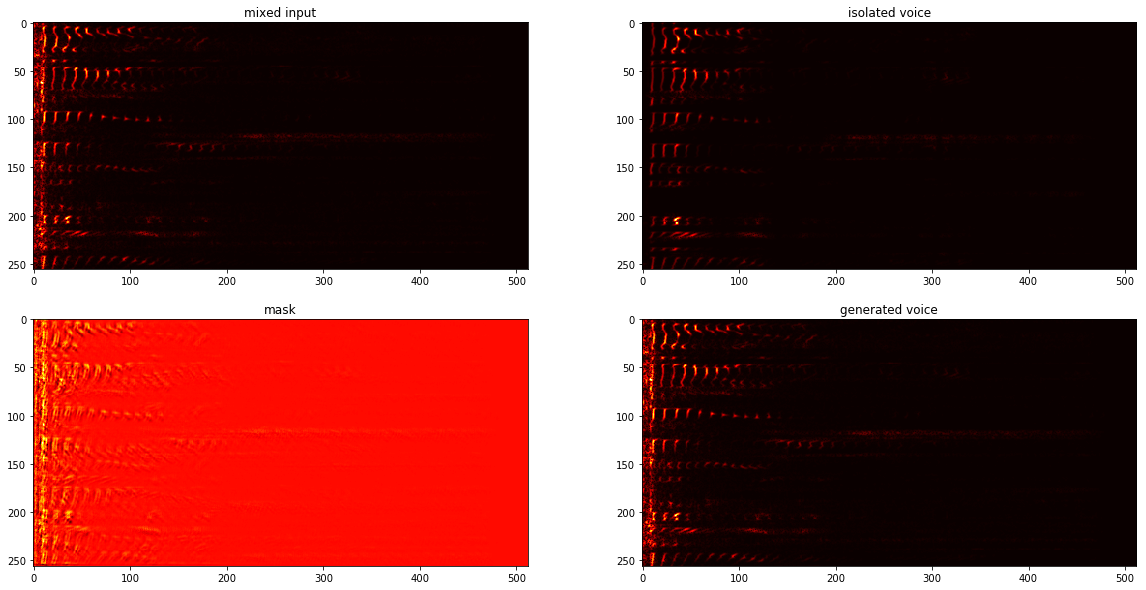

In [12]:
fig, ax = plt.subplots(2,2, figsize=(20,10))

ax[0,0].imshow(mix[0,:,:,0])
ax[0,0].set_title('mixed input')
ax[0,1].imshow(voice[0,:,:,0])
ax[0,1].set_title('isolated voice')
ax[1,0].imshow(mask[0,:,:,0])
ax[1,0].set_title('mask')
ax[1,1].imshow(mix[0,:,:,0] * mask[0,:,:,0])
ax[1,1].set_title('generated voice')
plt.show()

In [13]:
for i in range(5):
    _, mix, phase, voice, mask, cost = sess.run([model.train_op, model.mixed_mag, model.mixed_phase, 
                                                 model.voice_mag, model.reconstruction, model.cost])
    
    print(cost)

0.14993098
0.14298588
0.13855986
0.13293473
0.12863111


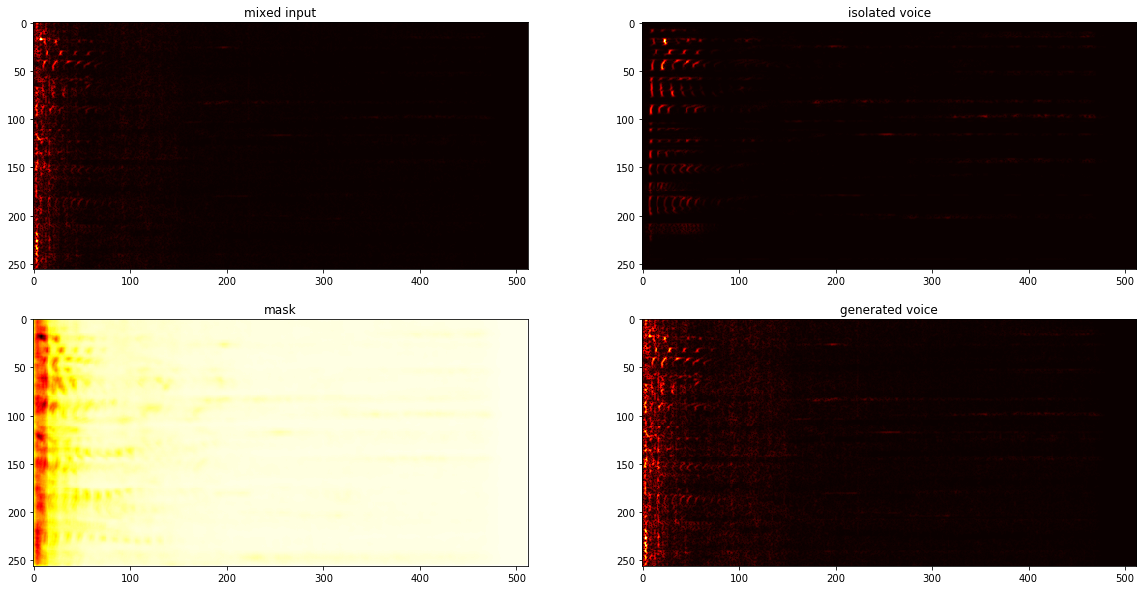

In [14]:
fig, ax = plt.subplots(2,2, figsize=(20,10))

ax[0,0].imshow(mix[0,:,:,0])
ax[0,0].set_title('mixed input')
ax[0,1].imshow(voice[0,:,:,0])
ax[0,1].set_title('isolated voice')
ax[1,0].imshow(mask[0,:,:,0])
ax[1,0].set_title('mask')
ax[1,1].imshow(mix[0,:,:,0] * mask[0,:,:,0])
ax[1,1].set_title('generated voice')
plt.show()

In [17]:
mix_wave = []
voice_wave = []
gen_wave = []

for i in range(mix.shape[0]):
    mix_wave.append(af.spectrogramToAudioFile(np.squeeze(mix[i, :, :, :]).T, n_fft,
                                                    fft_hop, phase=np.squeeze(phase[i, :, :, :]).T))
    voice_wave.append(af.spectrogramToAudioFile(np.squeeze(voice[i, :, :, :]).T, n_fft,
                                                    fft_hop, phase=np.squeeze(phase[i, :, :, :]).T))
    gen_wave.append(af.spectrogramToAudioFile(np.squeeze(mix[i, :, :, :] * mask[i, :, :, :]).T, n_fft,
                                                    fft_hop, phase=np.squeeze(phase[i, :, :, :]).T))

In [18]:
#  The original mixture
ipd.Audio(mix_wave[0], rate=sample_rate)

In [19]:
#  The isolated voice
ipd.Audio(voice_wave[0], rate=sample_rate)

In [20]:
#  The model output
ipd.Audio(gen_wave[0], rate=sample_rate)

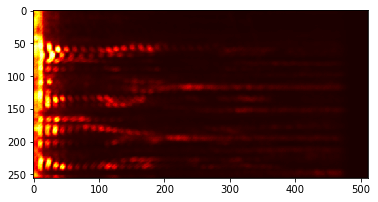

In [26]:
plt.imshow(mask[4,:,:,0])
plt.show()

In [27]:
mix[0,:,:,0] * mask[0,:,:,0]

array([[-5.0569884e-03, -5.7836971e-03, -5.0088852e-03, ...,
        -2.6976075e-05, -2.7100270e-05, -2.7227497e-05],
       [-2.5801598e-03, -2.4835188e-03, -2.9855447e-03, ...,
        -1.3370074e-05, -1.3450059e-05, -1.3529405e-05],
       [-1.0513234e-03, -1.4529580e-03, -1.1897365e-03, ...,
        -9.3385899e-10, -7.4495449e-10, -8.8694996e-10],
       ...,
       [-1.3483426e-03, -2.0559879e-03, -1.2686565e-03, ...,
        -1.2733377e-09, -1.1517449e-09, -1.2099299e-09],
       [-5.5519748e-04, -2.2334617e-03, -2.3192398e-03, ...,
        -1.3465412e-09, -1.3525240e-09, -1.3353096e-09],
       [-2.0629312e-03, -2.0662209e-03, -1.5632723e-03, ...,
        -1.5739224e-09, -1.2973437e-09, -1.3384328e-09]], dtype=float32)

In [28]:
voice[0,:,:,0]

array([[1.4361151e-03, 8.8377215e-04, 1.9309635e-03, ..., 6.8723512e-06,
        6.8663089e-06, 6.8649751e-06],
       [1.6330592e-03, 1.0971494e-03, 1.0463890e-03, ..., 3.4345765e-06,
        3.4327882e-06, 3.4329103e-06],
       [2.0441631e-04, 7.9773209e-04, 3.6544944e-04, ..., 1.1757737e-09,
        1.2669323e-09, 1.3244601e-09],
       ...,
       [1.1946444e-03, 2.9245354e-04, 6.9681869e-04, ..., 7.0546498e-08,
        7.1550225e-08, 6.4761196e-08],
       [1.8416357e-03, 3.7845757e-04, 2.7591523e-04, ..., 8.5275516e-08,
        4.3134726e-08, 4.2116216e-10],
       [1.0766893e-03, 1.7811731e-03, 2.0995438e-03, ..., 8.2260151e-08,
        6.5157479e-08, 5.7084325e-08]], dtype=float32)